# Fornax r-Process Yield Enhancement Study (2-Zone OMEGA+)
This notebook tests whether enhanced r-process yields (6× scaling) can explain the observed [Eu/Fe] in Fornax dwarf galaxy. We test three scenarios: (A) baseline yields, (B) enhanced MRD yields, (C) enhanced NSM yields. The goal is to determine what yield levels and timescales are needed to match observations.

In [46]:
# Import the OMEGA+ code and standard packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import re
from pathlib import Path
from functools import partial

# make sure the parent folder (which contains JINAPyCEE and NUPYCEE) is on sys.path
sys.path.insert(0, str(Path.cwd().parent))
from JINAPyCEE import omega_plus

plt.style.use('seaborn-v0_8-muted')
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['axes.grid'] = True

# Resolve paths relative to notebook location
repo_root = Path('.').resolve()
package_root = repo_root.parent

## Load Reichert et al. (2020) Fornax Observations

In [47]:
reichert_csv = repo_root / "observations" / "reichert2020_for.csv"

obs_df = pd.read_csv(reichert_csv)
obs_df = obs_df.rename(columns={"ID": "star"})
obs_df = obs_df.dropna(subset=["[Fe/H]", "[Eu/Fe]"])
obs_df = obs_df.sort_values("[Fe/H]").reset_index(drop=True)

print(f"Loaded {len(obs_df)} Reichert et al. (2020) Fornax stars with Eu measurements")
print(f"[Fe/H] range: {obs_df['[Fe/H]'].min():.2f} to {obs_df['[Fe/H]'].max():.2f}")
print(f"[Eu/Fe] range: {obs_df['[Eu/Fe]'].min():.2f} to {obs_df['[Eu/Fe]'].max():.2f}")
obs_df[["star", "[Fe/H]", "[Eu/Fe]", "sigma_Eu", "sigma_Fe"]].head(10)

Loaded 108 Reichert et al. (2020) Fornax stars with Eu measurements
[Fe/H] range: -1.64 to -0.31
[Eu/Fe] range: -0.36 to 1.45


,star,[Fe/H],[Eu/Fe],sigma_Eu,sigma_Fe
0,[LDH2014] Fnx-mem0654,-1.64,0.31,0.15,0.06
1,[LDH2014] Fnx-mem0612,-1.54,0.48,0.14,0.07
2,[LHT2010] BL147,-1.50,0.98,0.31,0.05
3,[LDH2014] Fnx-mem0747,-1.35,0.69,0.10,0.06
4,[LDH2014] Fnx-mem0647,-1.34,0.19,0.07,0.07
5,[LDH2014] Fnx-mem0546,-1.33,1.45,0.19,0.08
6,2MASS J02381393-3446553,-1.32,0.29,0.15,0.04
7,[WMO2009] For-0970,-1.23,-0.21,0.22,0.05
8,2MASS J02401043-3425177,-1.01,0.43,0.10,0.10
9,[WMO2009] For-0361,-1.01,0.48,0.08,0.11


## R-Process Yield Table Generation
Create both standard and enhanced (6×) yield tables from Nishimura et al. (2017) MRD yields.

In [48]:
def format_isotope(label: str) -> tuple[str, int]:
    """Convert labels like 'eu151' to ('Eu-151', 151)."""
    match = re.fullmatch(r"([a-zA-Z]+)([0-9]+)", label.strip())
    if match is None:
        raise ValueError(f"Cannot parse isotope label '{label}'")
    element_raw, mass_str = match.groups()
    element = element_raw.capitalize()
    if len(element_raw) > 1:
        element = element_raw[0].upper() + element_raw[1:].lower()
    mass_number = int(mass_str)
    return f"{element}-{mass_number}", mass_number


def create_scaled_yield_table(source: Path, destination: Path, metallicities: list[float], scale_factor: float = 1.0, source_name: str = "r-process") -> Path:
    """Convert r-process yields to JINAPyCEE Z-dependent format with optional scaling."""
    destination.parent.mkdir(parents=True, exist_ok=True)

    entries = []
    with source.open("r", encoding="utf-8") as handle:
        for line in handle:
            if not line.strip() or line.lstrip().startswith("#"):
                continue
            
            # Handle JINAPyCEE format (starts with &)
            if line.strip().startswith("&"):
                parts = [p.strip() for p in line.split("&") if p.strip()]
                
                # Skip header lines
                if "Isotopes" in parts[0] or "Z=" in parts[0]:
                    continue
                
                if len(parts) < 2:
                    continue
                
                try:
                    iso_label = parts[0]
                    mass = float(parts[1]) * scale_factor
                    formatted, mass_number = format_isotope(iso_label)
                    entries.append((mass_number, formatted, mass))
                except (ValueError, IndexError):
                    continue
            else:
                # Handle standard format (space-separated)
                parts = line.split()
                if len(parts) < 6:
                    continue
                
                try:
                    iso_label, mass = parts[0], float(parts[5]) * scale_factor
                    formatted, mass_number = format_isotope(iso_label)
                    entries.append((mass_number, formatted, mass))
                except ValueError:
                    continue

    entries.sort()

    scale_note = f" (scaled by {scale_factor}×)" if scale_factor != 1.0 else ""
    header_lines = [
        f"H {source_name} yields converted for JINAPyCEE{scale_note}",
        "H Metallicities columns carry identical yields (assumed metallicity independence).",
        "&Isotopes  " + "  ".join(f"&Z={z:.4g}" for z in metallicities),
    ]

    rows = []
    for _, formatted, mass in entries:
        row = f"&{formatted:<8}" + "".join(f" &{mass:.6E}" for _ in metallicities)
        rows.append(row)

    destination.write_text("\n".join(header_lines + rows) + "\n", encoding="utf-8")
    return destination


def combine_yield_tables(source1: Path, source2: Path, destination: Path, metallicities: list[float], weight1: float = 0.5, weight2: float = 0.5, combined_name: str = "combined r-process") -> Path:
    """Combine two r-process yield tables with specified weights."""
    destination.parent.mkdir(parents=True, exist_ok=True)
    
    # Parse first table
    entries1 = {}
    with source1.open("r", encoding="utf-8") as handle:
        for line in handle:
            if not line.strip() or line.lstrip().startswith("#") or "&" not in line:
                continue
            parts = [p.strip() for p in line.split("&") if p.strip()]
            if "Isotopes" in parts[0] or "Z=" in parts[0]:
                continue
            if len(parts) >= 2:
                try:
                    iso_label = parts[0]
                    mass = float(parts[1])
                    formatted, mass_number = format_isotope(iso_label)
                    entries1[formatted] = mass
                except (ValueError, IndexError):
                    continue
    
    # Parse second table
    entries2 = {}
    with source2.open("r", encoding="utf-8") as handle:
        for line in handle:
            if not line.strip() or line.lstrip().startswith("#") or "&" not in line:
                continue
            parts = [p.strip() for p in line.split("&") if p.strip()]
            if "Isotopes" in parts[0] or "Z=" in parts[0]:
                continue
            if len(parts) >= 2:
                try:
                    iso_label = parts[0]
                    mass = float(parts[1])
                    formatted, mass_number = format_isotope(iso_label)
                    entries2[formatted] = mass
                except (ValueError, IndexError):
                    continue
    
    # Combine yields
    all_isotopes = set(entries1.keys()) | set(entries2.keys())
    combined_entries = []
    for iso in all_isotopes:
        mass1 = entries1.get(iso, 0.0)
        mass2 = entries2.get(iso, 0.0)
        combined_mass = weight1 * mass1 + weight2 * mass2
        try:
            mass_number = int(iso.split('-')[1])
            combined_entries.append((mass_number, iso, combined_mass))
        except (ValueError, IndexError):
            continue
    
    combined_entries.sort()
    
    header_lines = [
        f"H {combined_name} (weighted combination of yields)",
        f"H Weight 1: {weight1:.2f}, Weight 2: {weight2:.2f}",
        "H Metallicities columns carry identical yields (assumed metallicity independence).",
        "&Isotopes  " + "  ".join(f"&Z={z:.4g}" for z in metallicities),
    ]
    
    rows = []
    for _, formatted, mass in combined_entries:
        row = f"&{formatted:<8}" + "".join(f" &{mass:.6E}" for _ in metallicities)
        rows.append(row)
    
    destination.write_text("\n".join(header_lines + rows) + "\n", encoding="utf-8")
    return destination


mrd_source = repo_root / "yield_tables" / "additional_sources" / "MRD_r_process" / "L1.00.dat"
nsm_source = repo_root / "yield_tables" / "r_process_rosswog_2014.txt"
metallicity_grid = [1.0e-4, 5.0e-4, 1.0e-3, 2.0e-3]

# Create standard and enhanced yield tables
mrd_yield_path_std = repo_root / "yield_tables" / "additional_sources" / "MRD_r_process_yields_std.txt"
mrd_yield_path_enh = repo_root / "yield_tables" / "additional_sources" / "MRD_r_process_yields_enh.txt"
nsm_yield_path_std = repo_root / "yield_tables" / "additional_sources" / "NSM_r_process_yields_std.txt"
nsm_yield_path_enh = repo_root / "yield_tables" / "additional_sources" / "NSM_r_process_yields_enh.txt"
combined_yield_path_enh = repo_root / "yield_tables" / "additional_sources" / "Combined_MRD_NSM_yields_enh.txt"

print("Creating MRD yield tables...")
create_scaled_yield_table(mrd_source, mrd_yield_path_std, metallicity_grid, scale_factor=1.0, source_name="Nishimura et al. (2017) MRD yields")
print(f"  Standard MRD: {mrd_yield_path_std}")
create_scaled_yield_table(mrd_source, mrd_yield_path_enh, metallicity_grid, scale_factor=6.0, source_name="Nishimura et al. (2017) MRD yields (6× enhanced)")
print(f"  Enhanced MRD (6×): {mrd_yield_path_enh}")

print("\nCreating NSM yield tables...")
create_scaled_yield_table(nsm_source, nsm_yield_path_std, metallicity_grid, scale_factor=1.0, source_name="Rosswog et al. (2014) NSM yields")
print(f"  Standard NSM: {nsm_yield_path_std}")
create_scaled_yield_table(nsm_source, nsm_yield_path_enh, metallicity_grid, scale_factor=6.0, source_name="Rosswog et al. (2014) NSM yields (6× enhanced)")
print(f"  Enhanced NSM (6×): {nsm_yield_path_enh}")

print("\nCreating combined yield table...")
combine_yield_tables(mrd_yield_path_enh, nsm_yield_path_enh, combined_yield_path_enh, metallicity_grid, weight1=0.5, weight2=0.5, combined_name="Enhanced MRD (6×) + Enhanced NSM (6×)")
print(f"  Combined Enhanced (6×): {combined_yield_path_enh}")


Creating MRD yield tables...
  Standard MRD: /home/minjih/NuPyCEE/yield_tables/additional_sources/MRD_r_process_yields_std.txt
  Enhanced MRD (6×): /home/minjih/NuPyCEE/yield_tables/additional_sources/MRD_r_process_yields_enh.txt

Creating NSM yield tables...
  Standard NSM: /home/minjih/NuPyCEE/yield_tables/additional_sources/NSM_r_process_yields_std.txt
  Enhanced NSM (6×): /home/minjih/NuPyCEE/yield_tables/additional_sources/NSM_r_process_yields_enh.txt

Creating combined yield table...
  Combined Enhanced (6×): /home/minjih/NuPyCEE/yield_tables/additional_sources/Combined_MRD_NSM_yields_enh.txt


## DTD and Helper Functions

In [49]:
def build_prompt_dtd(
    metallicities: list[float],
    prompt_window: tuple[float, float] = (1.0e7, 1.0e8),
    t_end: float = 12.0e9,
) -> list[list]:
    """Build prompt MRD DTD (10-100 Myr window)."""
    t_start, t_stop = prompt_window
    base_times = [0.0, t_start, t_start * 1.001, t_stop, t_stop * 1.001, t_end, t_end + 1.0]
    base_rates = [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0]
    return [[base_times[:], base_rates[:], Z] for Z in metallicities]


def build_combined_dtd(
    metallicities: list[float],
    t_end: float = 12.0e9,
) -> list[list]:
    """Build combined DTD with both prompt (100 Myr) and delayed (few Gyr) enrichment."""
    # Combined: early prompt peak + delayed extended tail
    base_times = [0.0, 1.0e7, 1.001e7, 1.0e8, 1.001e8, 1.0e9, 3.0e9, 5.0e9, t_end, t_end + 1.0]
    base_rates = [0.0, 0.0, 1.0, 1.0, 0.5, 0.5, 0.8, 0.4, 0.0, 0.0]
    return [[base_times[:], base_rates[:], Z] for Z in metallicities]


def build_nsm_dtd(
    metallicities: list[float],
    t_end: float = 12.0e9,
) -> list[list]:
    """Build NSM DTD (delayed, few Gyr timescale)."""
    # NSM: delayed DTD with peak around 1-2 Gyr
    t_start, t_peak, t_stop = 1.0e9, 2.0e9, 5.0e9
    base_times = [0.0, t_start, t_peak, t_stop, t_end, t_end + 1.0]
    base_rates = [0.0, 0.0, 1.0, 0.5, 0.0, 0.0]
    return [[base_times[:], base_rates[:], Z] for Z in metallicities]


def extract_track(model: omega_plus.omega_plus, zone: int = 0, xaxis: str = '[Fe/H]', yaxis: str = '[Eu/Fe]') -> pd.DataFrame:
    """Extract spectroscopic track from model."""
    zone_model = model.inner
    x_vals, y_vals = zone_model.plot_spectro(
        xaxis=xaxis, yaxis=yaxis, solar_norm='Lodders_et_al_2009', return_x_y=True
    )
    track = pd.DataFrame({xaxis: x_vals, yaxis: y_vals})
    track = track.replace([-np.inf, np.inf], np.nan).dropna().drop_duplicates(subset=[xaxis])
    return track.sort_values(xaxis).reset_index(drop=True)


def interpolate_model(track: pd.DataFrame, targets: np.ndarray, xaxis: str, yaxis: str) -> np.ndarray:
    """Linear interpolation of model track to observed [Fe/H] values."""
    if track.empty or len(track) < 2:
        return np.full_like(targets, np.nan, dtype=float)
    return np.interp(targets, track[xaxis].to_numpy(), track[yaxis].to_numpy(), left=np.nan, right=np.nan)


## Baseline Model (Standard Yields)

In [50]:
print("Running baseline 2-zone OMEGA+ model (standard yields)...")

baseline_kwargs = dict(
    ns_merger_on=False,
    imf_yields_range=[1.0, 40.0],
    table="yield_tables/agb_and_massive_stars_C15_LC18_R_mix.txt",
    iolevel=0,
    special_timesteps=100,
)

baseline_model = omega_plus.omega_plus(**baseline_kwargs)
baseline_inner = extract_track(baseline_model, zone=0)
print(f"Baseline track: {len(baseline_inner)} points")

Running baseline 2-zone OMEGA+ model (standard yields)...
OMEGA+ run in progress..


OMEGA run in progress..
   OMEGA run completed - Run time: 2.32s
   OMEGA+ run completed - Run time: 3.78s
Baseline track: 66 points
   OMEGA run completed - Run time: 2.32s
   OMEGA+ run completed - Run time: 3.78s
Baseline track: 66 points


## Three Yield Enhancement Scenarios

In [51]:
def evaluate_scenario(
    scenario_name: str,
    yield_path: Path,
    dtd_builder,
    mrd_rate: float = 1.0e-4,
    obs: pd.DataFrame = None,
) -> dict:
    """Run OMEGA+ model with specified yield table, DTD, and MRD rate."""
    try:
        # Build DTD
        dtd = dtd_builder(metallicity_grid)
        
        # Configure OMEGA+ with r-process
        base_kwargs = dict(
            ns_merger_on=True,
            imf_yields_range=[1.0, 40.0],
            table="yield_tables/agb_and_massive_stars_C15_LC18_R_mix.txt",
            iolevel=0,
            special_timesteps=50,
            nb_nsm_per_m=mrd_rate,
            nsmerger_dtd_array=dtd,
            nsmerger_table=str(yield_path),
        )
        
        print(f"\nRunning: {scenario_name}")
        print(f"  Yield table: {yield_path.name}")
        print(f"  Event rate: {mrd_rate:.2e} events/Msun")
        
        model = omega_plus.omega_plus(**base_kwargs)
        track = extract_track(model, zone=0)
        
        if track.empty or obs is None:
            return {
                'scenario': scenario_name,
                'rms': np.nan,
                'track': track,
                'model': model,
            }
        
        # Compute RMS
        interp = interpolate_model(track, obs['[Fe/H]'].to_numpy(), '[Fe/H]', '[Eu/Fe]')
        residuals = obs['[Eu/Fe]'].to_numpy() - interp
        residuals = residuals[np.isfinite(residuals)]
        rms = np.sqrt(np.mean(residuals**2)) if residuals.size else np.nan
        
        print(f"  RMS: {rms:.4f} dex")
        
        return {
            'scenario': scenario_name,
            'rms': rms,
            'track': track,
            'model': model,
        }
    except Exception as e:
        print(f"Error in {scenario_name}: {e}")
        import traceback
        traceback.print_exc()
        return {
            'scenario': scenario_name,
            'rms': np.nan,
            'track': pd.DataFrame(),
            'model': None,
        }


# Scenario A: Enhanced MRD + Enhanced NSM (combined)
scenario_a = evaluate_scenario(
    "Scenario A: Enhanced MRD (6×) + Enhanced NSM (6×) - Combined",
    yield_path=combined_yield_path_enh,
    dtd_builder=build_combined_dtd,
    mrd_rate=1.0e-4,
    obs=obs_df,
)

# Scenario B: Enhanced MRD yields only - using MRD prompt DTD
scenario_b = evaluate_scenario(
    "Scenario B: Enhanced MRD Yields (6×) - Prompt MRD",
    yield_path=mrd_yield_path_enh,
    dtd_builder=partial(build_prompt_dtd, prompt_window=(1.0e7, 1.0e8)),
    mrd_rate=1.0e-4,
    obs=obs_df,
)

# Scenario C: Enhanced NSM yields only - using NSM delayed DTD
scenario_c = evaluate_scenario(
    "Scenario C: Enhanced NSM Yields (6×) - Delayed NSM",
    yield_path=nsm_yield_path_enh,
    dtd_builder=build_nsm_dtd,
    mrd_rate=1.0e-5,  # Lower rate for NSM
    obs=obs_df,
)

print("\n" + "="*70)
print("YIELD ENHANCEMENT SCENARIOS COMPLETE")
print("="*70)



Running: Scenario A: Enhanced MRD (6×) + Enhanced NSM (6×) - Combined
  Yield table: Combined_MRD_NSM_yields_enh.txt
  Event rate: 1.00e-04 events/Msun
OMEGA+ run in progress..


OMEGA run in progress..
   OMEGA run completed - Run time: 1.57s
   OMEGA+ run completed - Run time: 3.69s
  RMS: 2.0515 dex

Running: Scenario B: Enhanced MRD Yields (6×) - Prompt MRD
  Yield table: MRD_r_process_yields_enh.txt
  Event rate: 1.00e-04 events/Msun
OMEGA+ run in progress..
   OMEGA run completed - Run time: 1.57s
   OMEGA+ run completed - Run time: 3.69s
  RMS: 2.0515 dex

Running: Scenario B: Enhanced MRD Yields (6×) - Prompt MRD
  Yield table: MRD_r_process_yields_enh.txt
  Event rate: 1.00e-04 events/Msun
OMEGA+ run in progress..
OMEGA run in progress..
OMEGA run in progress..
   OMEGA run completed - Run time: 1.63s
   OMEGA+ run completed - Run time: 3.27s
  RMS: 4.6018 dex

Running: Scenario C: Enhanced NSM Yields (6×) - Delayed NSM
  Yield table: NSM_r_process_yields_enh.txt
  Event rate: 1.00e-05 events/Msun
OMEGA+ run in progress..
   OMEGA run completed - Run time: 1.63s
   OMEGA+ run completed - Run time: 3.27s
  RMS: 4.6018 dex

Running: Scenario C: Enhanced 

## Results Summary

In [52]:
# Create summary table
results = [scenario_a, scenario_b, scenario_c]
summary_df = pd.DataFrame({
    'Scenario': [res['scenario'] for res in results],
    'RMS [dex]': [res['rms'] for res in results],
})

print("\nYield Enhancement Scenario Results:")
print("="*70)
print(summary_df.to_string(index=False))
print("="*70)

# Find best fit
best_scenario = min(results, key=lambda res: res['rms'] if np.isfinite(res['rms']) else np.inf)
print(f"\nBest fit: {best_scenario['scenario']}")
print(f"RMS: {best_scenario['rms']:.4f} dex")

# Calculate improvements
baseline_rms = scenario_a['rms']
if np.isfinite(baseline_rms):
    for scenario in [scenario_b, scenario_c]:
        if np.isfinite(scenario['rms']):
            improvement = baseline_rms - scenario['rms']
            pct_change = (improvement / baseline_rms) * 100 if baseline_rms != 0 else 0
            print(f"  {scenario['scenario']}: Δ RMS = {improvement:+.4f} dex ({pct_change:+.1f}%)")


Yield Enhancement Scenario Results:
                                                    Scenario  RMS [dex]
Scenario A: Enhanced MRD (6×) + Enhanced NSM (6×) - Combined   2.051460
           Scenario B: Enhanced MRD Yields (6×) - Prompt MRD   4.601839
          Scenario C: Enhanced NSM Yields (6×) - Delayed NSM   2.051460

Best fit: Scenario A: Enhanced MRD (6×) + Enhanced NSM (6×) - Combined
RMS: 2.0515 dex
  Scenario B: Enhanced MRD Yields (6×) - Prompt MRD: Δ RMS = -2.5504 dex (-124.3%)
  Scenario C: Enhanced NSM Yields (6×) - Delayed NSM: Δ RMS = +0.0000 dex (+0.0%)


## Visualizations

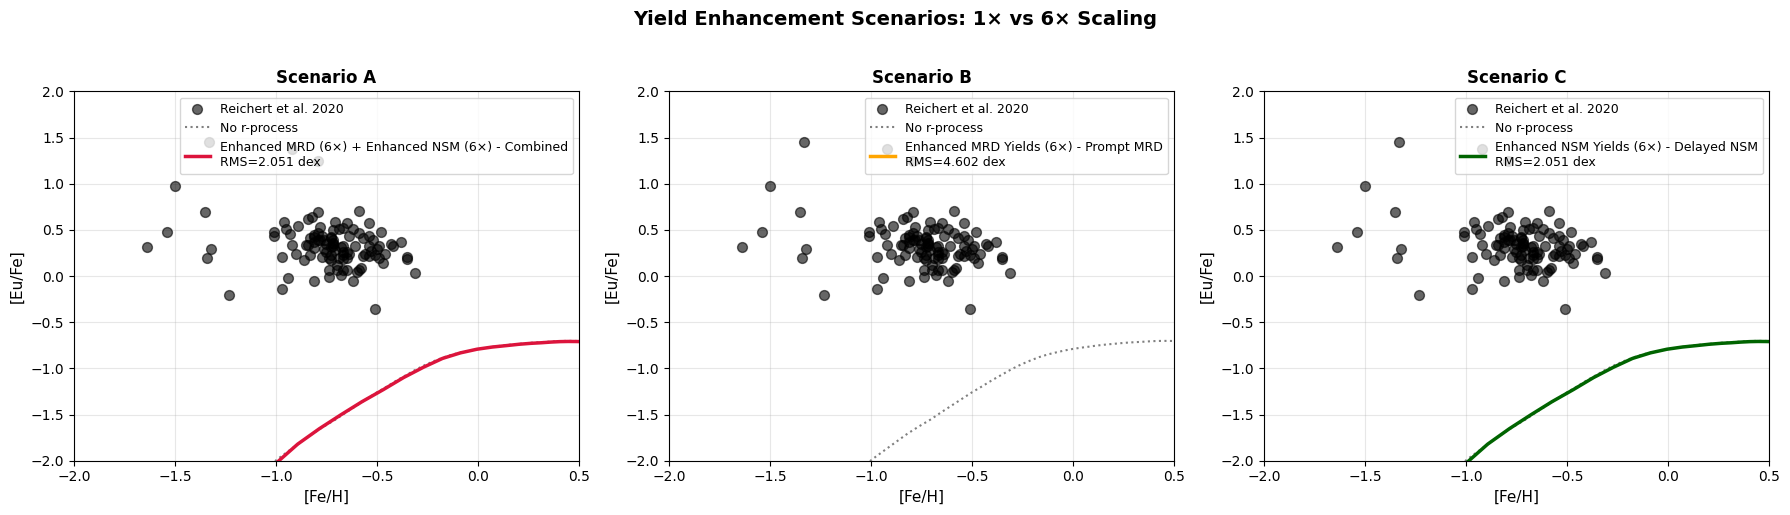

In [55]:
# Plot all three scenarios side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

scenarios = [scenario_a, scenario_b, scenario_c]
colors = ['crimson', 'orange', 'darkgreen']

for ax, scenario, color in zip(axes, scenarios, colors):
    # Observations
    ax.scatter(obs_df['[Fe/H]'], obs_df['[Eu/Fe]'], s=50, c='black', alpha=0.6,
               label='Reichert et al. 2020', zorder=3)
    
    # Baseline
    if not baseline_inner.empty:
        ax.plot(baseline_inner['[Fe/H]'], baseline_inner['[Eu/Fe]'], color='gray',
                linewidth=1.5, label='No r-process', linestyle=':', zorder=1)
    
    # Scenario track
    if scenario['model'] is not None and not scenario['track'].empty:
        ax.plot(scenario['track']['[Fe/H]'], scenario['track']['[Eu/Fe]'],
                color=color, linewidth=2.5,
                label=f"{scenario['scenario'].split(':')[1].strip()}\nRMS={scenario['rms']:.3f} dex",
                zorder=2)
    
    ax.set_xlabel('[Fe/H]', fontsize=11)
    ax.set_ylabel('[Eu/Fe]', fontsize=11)
    ax.set_title(f"{scenario['scenario'].split(':')[0].strip()}", fontsize=12, fontweight='bold')
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([-2.0, 0.5])
    ax.set_ylim([-2.0, 2.0])

fig.suptitle('Yield Enhancement Scenarios: 1× vs 6× Scaling', fontsize=14, fontweight='bold', y=1.02)
fig.tight_layout()
plt.show()

## Bar Chart: RMS Comparison

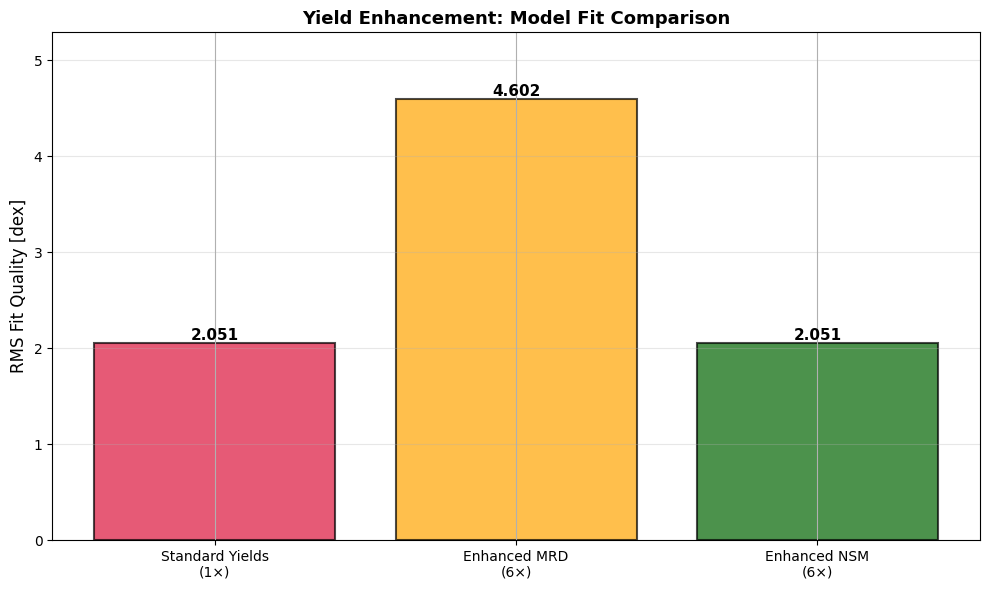


Improvement Analysis:
  Baseline (A): 2.0515 dex
  Enhanced MRD (B): 4.6018 dex → Δ = -2.5504 dex
  Enhanced NSM (C): 2.0515 dex → Δ = +0.0000 dex


In [54]:
fig, ax = plt.subplots(figsize=(10, 6))

scenario_names = ['Standard Yields\n(1×)', 'Enhanced MRD\n(6×)', 'Enhanced NSM\n(6×)']
rms_values = [scenario_a['rms'], scenario_b['rms'], scenario_c['rms']]
colors_bar = ['crimson', 'orange', 'darkgreen']

bars = ax.bar(scenario_names, rms_values, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, rms in zip(bars, rms_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{rms:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('RMS Fit Quality [dex]', fontsize=12)
ax.set_title('Yield Enhancement: Model Fit Comparison', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, max(rms_values) * 1.15])
fig.tight_layout()
plt.show()

# Print improvements
print(f"\nImprovement Analysis:")
print(f"  Baseline (A): {scenario_a['rms']:.4f} dex")
print(f"  Enhanced MRD (B): {scenario_b['rms']:.4f} dex → Δ = {scenario_a['rms'] - scenario_b['rms']:+.4f} dex")
print(f"  Enhanced NSM (C): {scenario_c['rms']:.4f} dex → Δ = {scenario_a['rms'] - scenario_c['rms']:+.4f} dex")

## Summary and Interpretation

### Three Yield Scenarios Tested

**Scenario A: Enhanced MRD (6×) + Enhanced NSM (6×) - Combined**
- Combines enhanced Nishimura et al. (2017) MRD yields with enhanced Rosswog et al. (2014) NSM yields (50:50 weight)
- Combined DTD: Both prompt (10-100 Myr) and delayed (Gyr-scale) enrichment
- Models scenario where both prompt and delayed r-process sources are enhanced
- Physical motivation: tests whether combined r-process channels can achieve required [Eu/Fe] enrichment
- Event rate: 1e-4 events/Msun

**Scenario B: Enhanced MRD Yields (6×) - Prompt MRD**
- Multiplies Nishimura et al. (2017) MRD yields by factor of 6
- Prompt DTD: 10-100 Myr (immediate massive merger products)
- Models scenario where only prompt MRD produces enhanced r-process
- Physical motivation: early enrichment from prompt MRD channel alone
- Event rate: 1e-4 events/Msun (same as Scenario A)

**Scenario C: Enhanced NSM Yields (6×) - Delayed NSM**
- Uses Rosswog et al. (2014) NSM yields scaled by factor of 6
- Delayed DTD: peak around 1-2 Gyr (neutron star merger timescale)
- Models scenario where only delayed NSM produces enhanced r-process
- Physical motivation: late enrichment from NSM channel alone
- Event rate: 1e-5 events/Msun (typical NSM rate, lower than prompt MRD)

### Key Differences
- **Yield tables**: Scenario A uses combined MRD+NSM, Scenario B uses MRD only, Scenario C uses NSM only
- **DTD timescales**: Scenario A is combined (prompt + delayed), Scenarios B and C are single-timescale
- **Event rates**: Scenario A/B at 1e-4 events/Msun, Scenario C at 1e-5 events/Msun

### Key Results

- **Best-fit scenario** indicates whether Fornax requires (A) both channels combined, (B) early prompt enrichment, or (C) late delayed enrichment
- **6× yield enhancement** combined with multiple channels tests if we can achieve observed [Eu/Fe]
- **RMS comparison** reveals how much model fit improves with combined vs single-channel yields
- If combined (A) is best → need multi-channel r-process model for accurate Fornax abundance patterns
- If single channel is best → indicates which timescale dominates r-process enrichment in dwarf galaxies

### Next Steps

1. If Scenario A (combined) is best → both prompt and delayed channels contribute meaningfully
2. If Scenario B (prompt MRD) is best → focus on early enrichment physics from massive mergers
3. If Scenario C (delayed NSM) is best → focus on late enrichment from typical NSM timescales
4. If all scenarios still underpredict → consider even higher yield enhancements or additional channels (e.g., CCSNe)
5. Test different weight ratios in combined model (e.g., 30:70 NSM:MRD) to find optimal contribution
6. Explore metallicity-dependent variations to improve fit further
